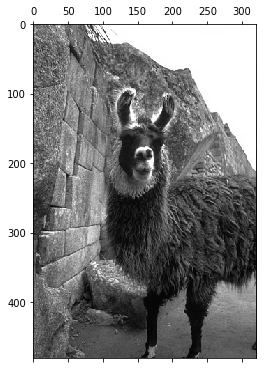

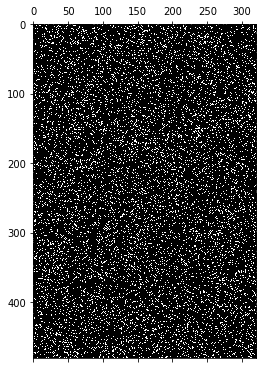

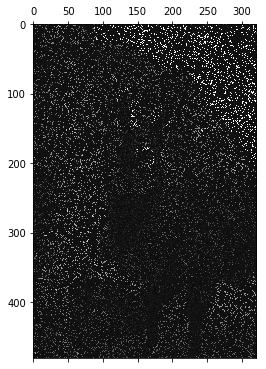

In [125]:
import numpy as np
from numpy.linalg import matrix_rank as rank
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray

path = "/home/sircrashalot/Schreibtisch/Mathematik/Master/S03/compressed sensing/project/training_set/03inpainting/03Inpainting/data/BSDS500/6046.jpg"

# load the image
image = Image.open(path).convert('L')
# convert image to numpy array
A = asarray(image)
m,n = A.shape


def lowrank_missing(A, p, k, noise=0.0):
    """
    Generates an image A' where we have the rank k and missing entries.
    The given entries have optional noise.
    
    Input:
        A : the image we wish to corrupt
        p : the probability that a given entry is missing in the final image
        k : the rank of the final corrupted image
        noise : the additive noise factor for our given entries. We assume that 
                our noise satisfies the normal distribution N(0,noise).
    """

    
    m,n = A.shape
    #print(m,n)
    mask = np.random.choice(np.arange(0,2), p=[p, 1-p], size=(m,n))
    noise_matrix = np.random.normal(loc=0, scale = noise, size=(m,n))
    
    A_masked = np.multiply(A + noise_matrix,mask)
    U, s, VT = np.linalg.svd(A_masked, full_matrices=True )
    r = rank(A_masked)
    s[n-k:] = 0
    #print(s)
    S = np.zeros((m, n), dtype=np.float)
    S[:n, :n] = np.diag(s)
    mask_rec = U@(S@VT)
    return (mask_rec, mask)
                        
                        
                        
k = 33
prob = 0.88          
A_noisy, mask = lowrank_missing(A, prob, k)

plt.matshow(A, cmap="gray")
plt.matshow(mask, cmap="gray")
plt.matshow(A_noisy, cmap="gray")


### Image reconstruction in the noiseless case via DRS

We are trying to solve the minimization problem $$\min_X ||X||_* \ \ \ s. t. \ \ \ AX = B$$
This can be done via Douglas-Rachford splitting. For a derivation see the report.

$$y^{(k)} = 2(z^{(k)} + A^T(B - Az^{(k)})) - z^{(k)}$$
$$z^{(k+1)} = z^{(k)} + \mathcal{D}_\gamma(y^{(k)}) - \mathcal{D}_\gamma(z^{(k)})$$

In [ ]:
def D(X, gamma):
    """
    The singular value thresholding operator
    """
    m,n = X.shape
    U, s, VT = np.linalg.svd(X, full_matrices=True)
    st = np.max(0, s - gamma)
    S = np.zeros((m, n), dtype=np.float)
    S[:n, :n] = np.diag(s)
    Xt = U@(S@VT)
    
    return Xt

def P_omega(X, omega):
    """
    operator to encode the known entries in the set omega
    """
    n = omega.shape[0]
    
    
    